In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
(img_train, _), (_, _) = keras.datasets.mnist.load_data()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
img_train.shape

(60000, 28, 28)

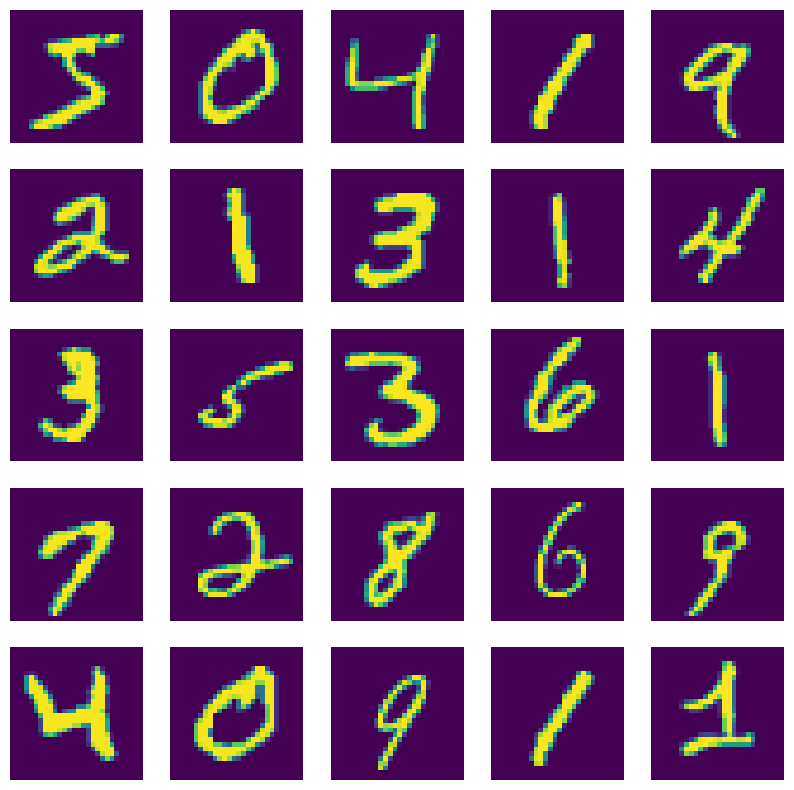

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(img_train[i])
  plt.axis("off")
plt.show()

In [ ]:
img_train = img_train.reshape(img_train.shape[0], 28,28,1 ).astype('float32')
img_train = (img_train - 127.5) / 127.5

In [ ]:
img_train.shape

(60000, 28, 28, 1)

In [ ]:
BUFFER_SIZE = 70000
BATCH_SIZE = 64

In [ ]:
img_train

array([[[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        ...,

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]]],


       [[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(img_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
LATENT_DIM = 100
WEIGHT_UNIT = keras.initializers.RandomNormal(mean= 0.0, stddev=0.02)

In [ ]:


def build_generator():
    model = keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 256)),  # Reshapes to (7,7,256)

        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (4, 4), strides=(1, 1), padding='same', activation='tanh')  # Output (28,28,1)
    ])

    return model

generator = build_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
def build_discriminator():
    model = keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),  # Changed input_shape to (28, 28, 1)
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),  # Added Dropout
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),  # Added Dropout
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')  # Changed to sigmoid for binary classification
    ])
    return model
discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cross_entropy = keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)  # Label smoothing
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:

optimizer_gen = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_disc = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)  # Lower learning rate

In [ ]:
# GAN Class
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, g_loss, d_loss):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        noise = tf.random.normal([batch_size, LATENT_DIM])
        with tf.GradientTape() as d_tape:
            generated_images = self.generator(noise, training=True)
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            d_loss = self.d_loss(real_output, fake_output)

        d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        noise = tf.random.normal([batch_size, LATENT_DIM])
        with tf.GradientTape() as g_tape:
            generated_images = self.generator(noise, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            g_loss = self.g_loss(fake_output)

        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
#Callback to visualize generated images
class ImageCallback(keras.callbacks.Callback):
    def __init__(self, num_images=16, latent_dim=100):
        self.num_images = num_images
        self.latent_dim = latent_dim
        self.seed = tf.random.normal([num_images, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            generated_images = self.model.generator(self.seed, training=False)
            generated_images = (generated_images * 127.5) + 127.5

            plt.figure(figsize=(10,10))
            for i in range(self.num_images):
                plt.subplot(4, 4, i+1)
                plt.imshow(generated_images[i].numpy().astype("uint8"))
                plt.axis("off")
            plt.show()

In [ ]:
EPOCH = 100

In [ ]:

gan = GAN(generator=generator, discriminator=discriminator)  # Changed 'generator' to 'genrator'
gan.compile(
    g_optimizer=optimizer_gen,
    d_optimizer=optimizer_disc,
    g_loss=generator_loss,
    d_loss=discriminator_loss
)

Epoch 1/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - d_loss: 1.3576 - g_loss: 0.8129

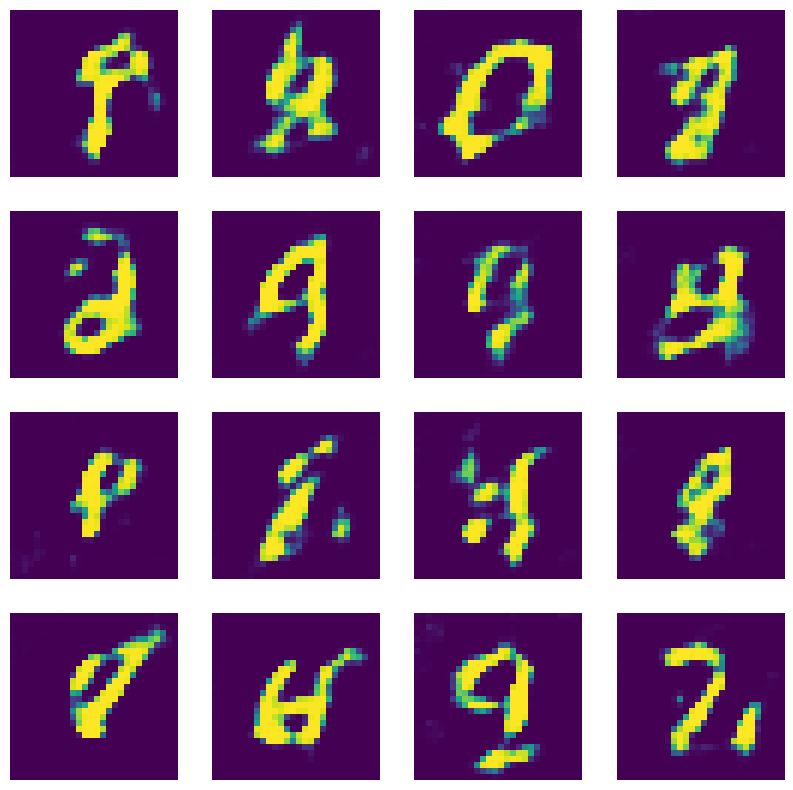

938/938 ━━━━━━━━━━━━━━━━━━━━ 49s 29ms/step - d_loss: 1.3576 - g_loss: 0.8130
Epoch 2/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - d_loss: 1.3474 - g_loss: 0.8327
Epoch 3/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3519 - g_loss: 0.8346
Epoch 4/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - d_loss: 1.3478 - g_loss: 0.8386
Epoch 5/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3462 - g_loss: 0.8445
Epoch 6/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - d_loss: 1.3454 - g_loss: 0.8464

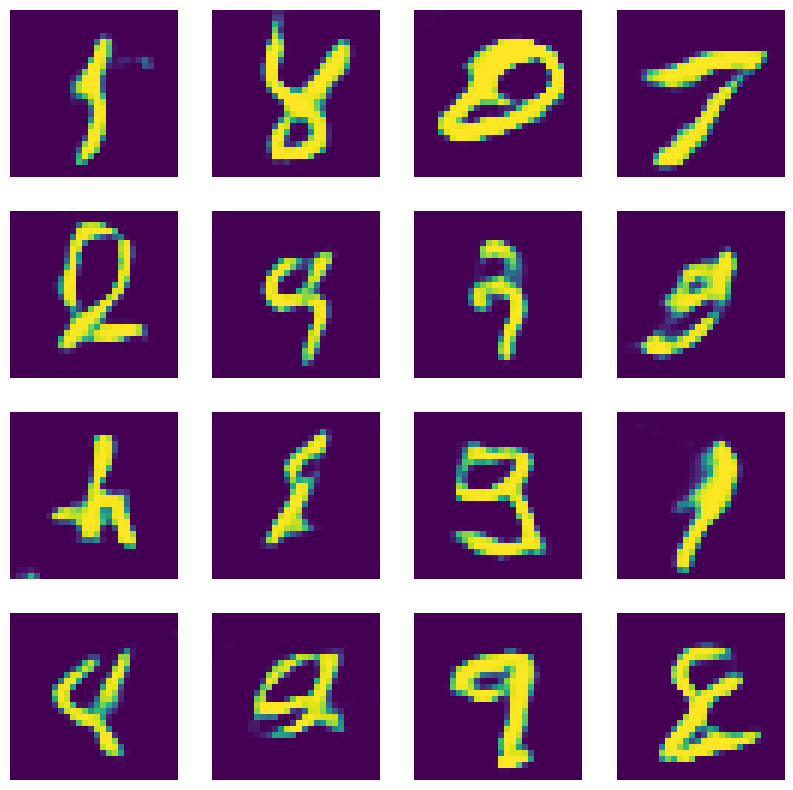

938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3453 - g_loss: 0.8464
Epoch 7/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3462 - g_loss: 0.8478
Epoch 8/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3470 - g_loss: 0.8445
Epoch 9/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3485 - g_loss: 0.8482
Epoch 10/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3496 - g_loss: 0.8496
Epoch 11/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - d_loss: 1.3485 - g_loss: 0.8444

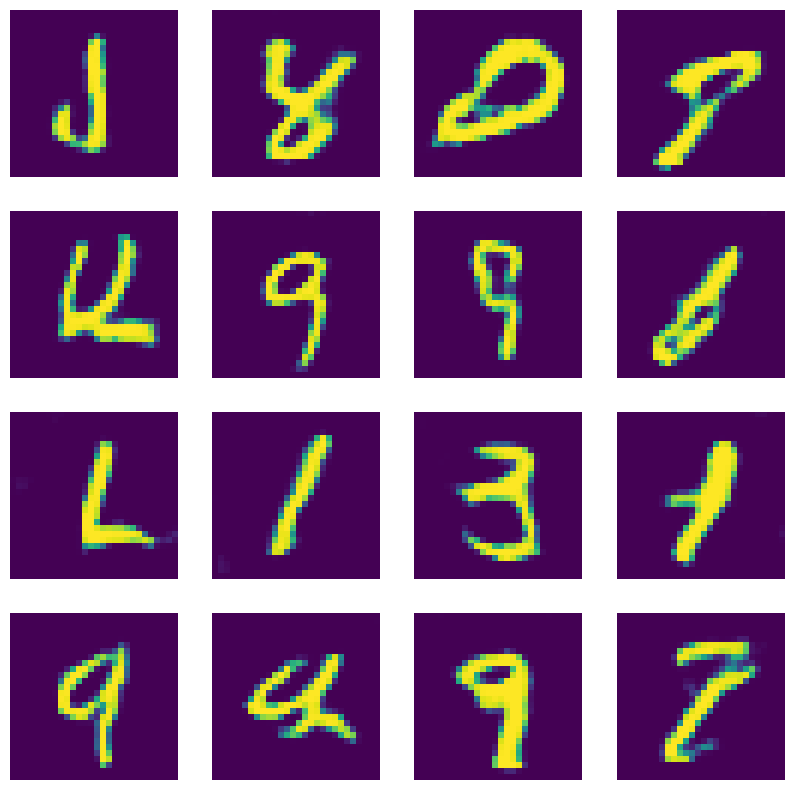

938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3483 - g_loss: 0.8442
Epoch 12/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3489 - g_loss: 0.8435
Epoch 13/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - d_loss: 1.3498 - g_loss: 0.8455
Epoch 14/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - d_loss: 1.3489 - g_loss: 0.8484
Epoch 15/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3483 - g_loss: 0.8454
Epoch 16/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - d_loss: 1.3479 - g_loss: 0.8493

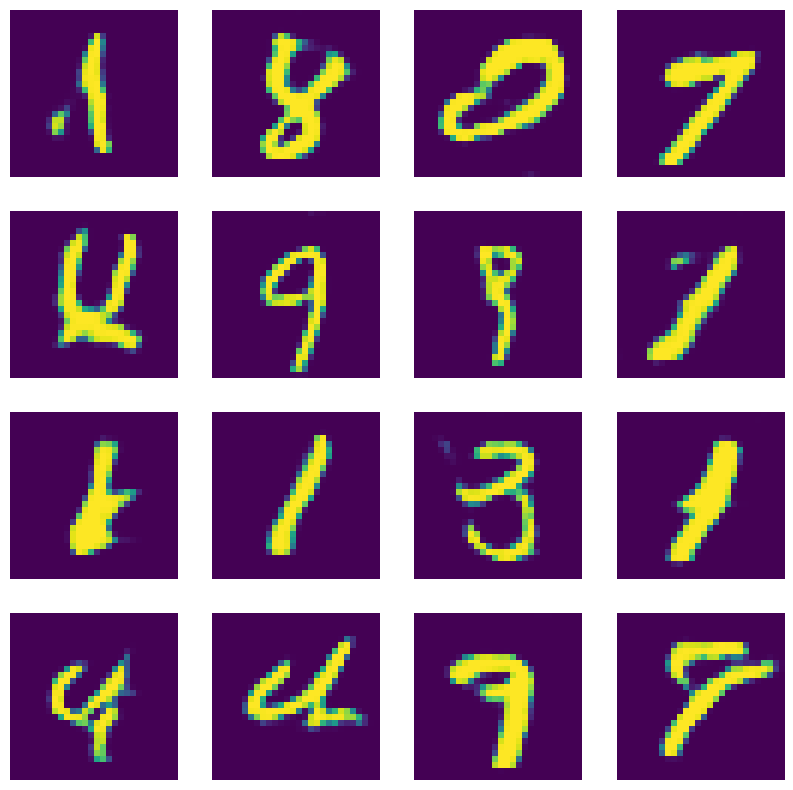

938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3480 - g_loss: 0.8491
Epoch 17/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3484 - g_loss: 0.8453
Epoch 18/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - d_loss: 1.3473 - g_loss: 0.8494
Epoch 19/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3472 - g_loss: 0.8496
Epoch 20/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - d_loss: 1.3466 - g_loss: 0.8493
Epoch 21/100
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - d_loss: 1.3473 - g_loss: 0.8486

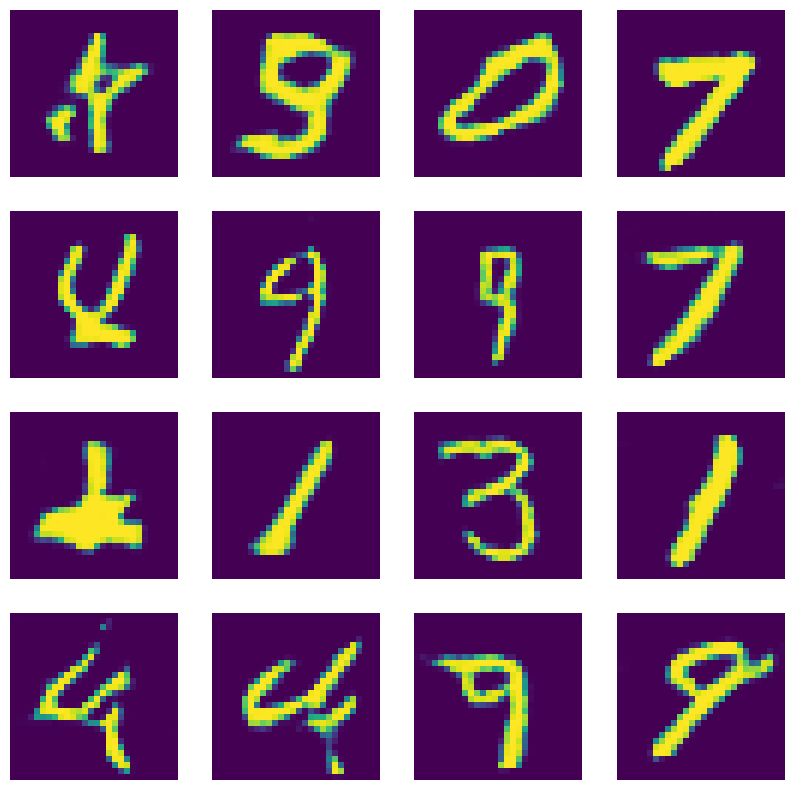

938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - d_loss: 1.3474 - g_loss: 0.8486
Epoch 22/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - d_loss: 1.3459 - g_loss: 0.8519
Epoch 23/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - d_loss: 1.3479 - g_loss: 0.8501
Epoch 24/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3467 - g_loss: 0.8494
Epoch 25/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3475 - g_loss: 0.8495
Epoch 26/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - d_loss: 1.3456 - g_loss: 0.8509

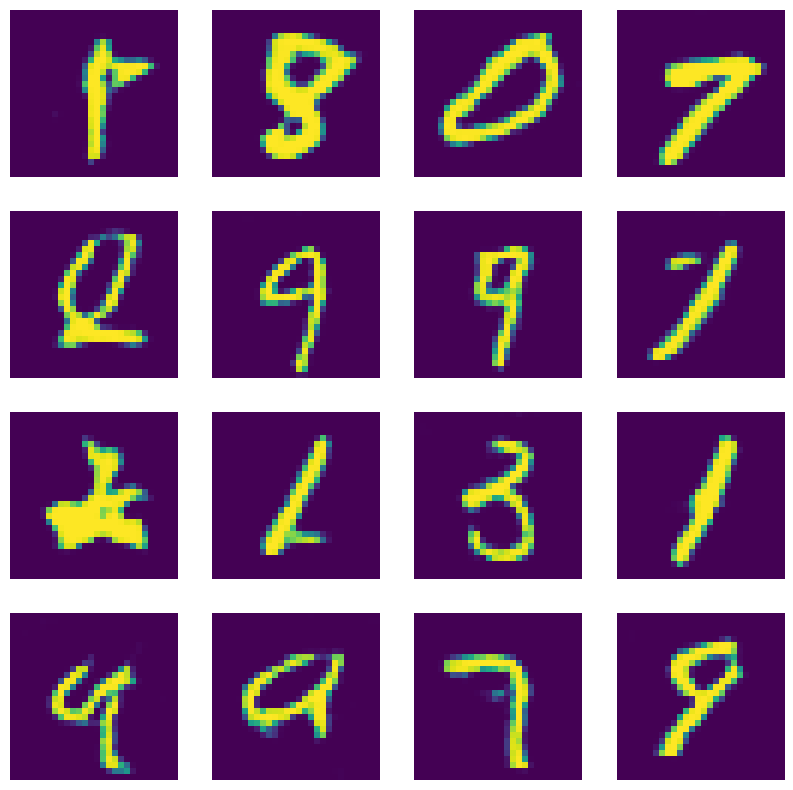

938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - d_loss: 1.3456 - g_loss: 0.8509
Epoch 27/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3463 - g_loss: 0.8503
Epoch 28/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3470 - g_loss: 0.8520
Epoch 29/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3455 - g_loss: 0.8512
Epoch 30/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - d_loss: 1.3473 - g_loss: 0.8505
Epoch 31/100
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - d_loss: 1.3459 - g_loss: 0.8511

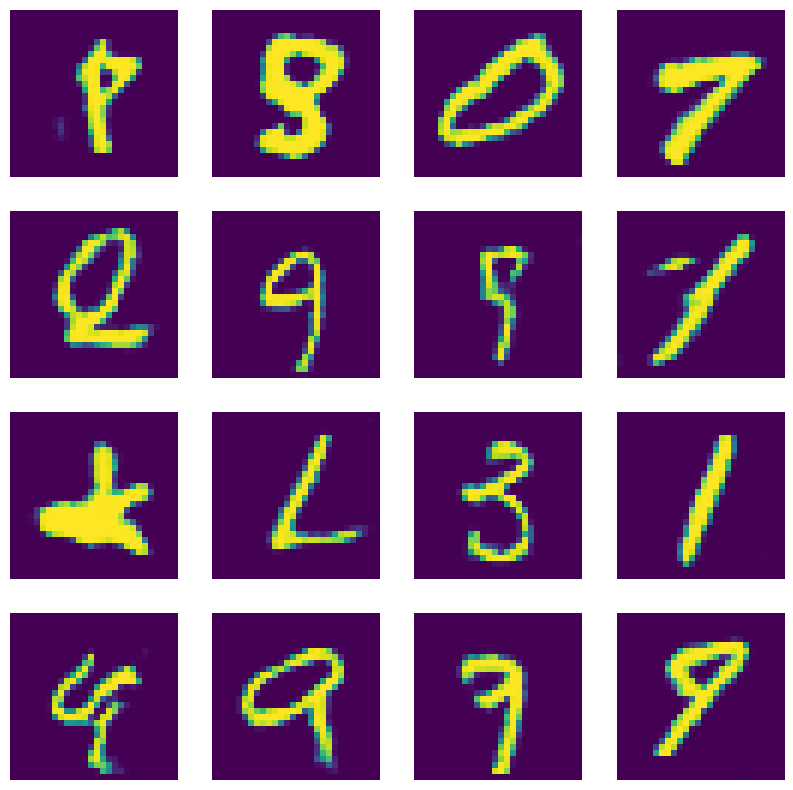

938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - d_loss: 1.3459 - g_loss: 0.8509
Epoch 32/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - d_loss: 1.3468 - g_loss: 0.8500
Epoch 33/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - d_loss: 1.3466 - g_loss: 0.8517
Epoch 34/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3470 - g_loss: 0.8521
Epoch 35/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3477 - g_loss: 0.8515
Epoch 36/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - d_loss: 1.3486 - g_loss: 0.8490

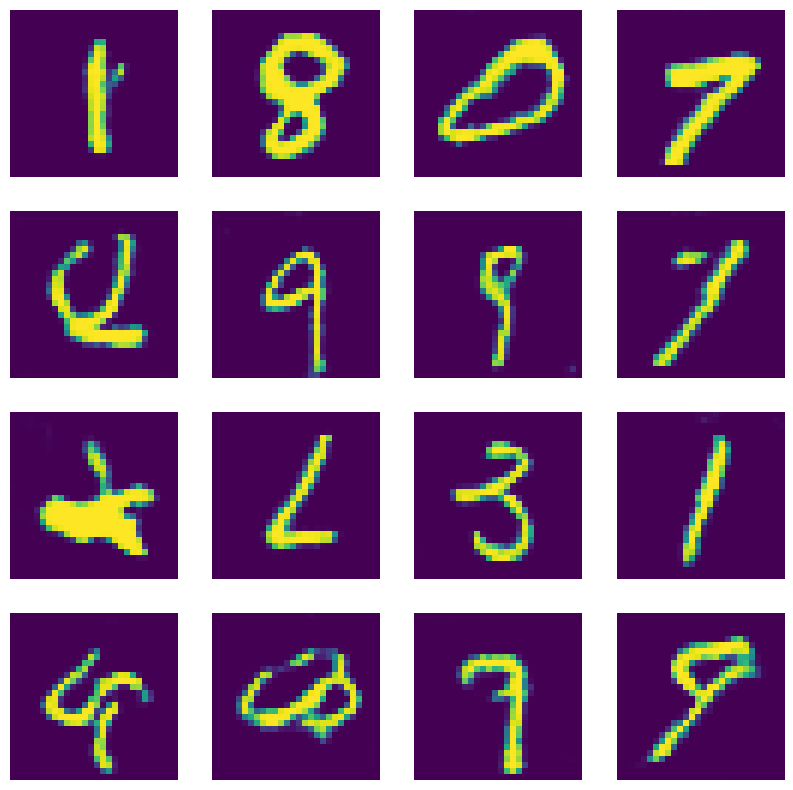

938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - d_loss: 1.3486 - g_loss: 0.8491
Epoch 37/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - d_loss: 1.3468 - g_loss: 0.8510
Epoch 38/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3465 - g_loss: 0.8515
Epoch 39/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - d_loss: 1.3458 - g_loss: 0.8502
Epoch 40/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - d_loss: 1.3443 - g_loss: 0.8531
Epoch 41/100
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - d_loss: 1.3444 - g_loss: 0.8523

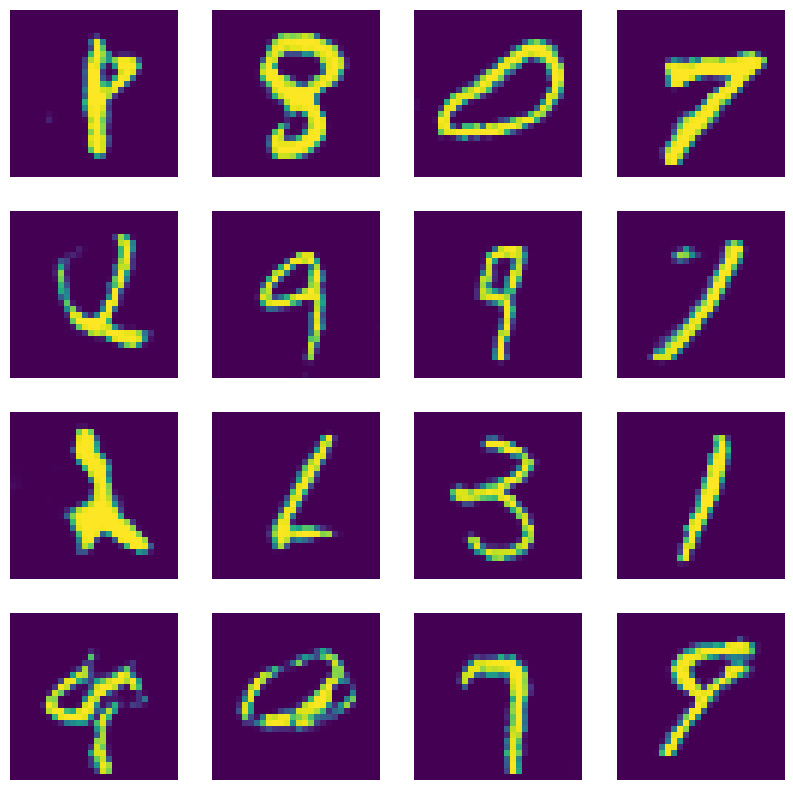

938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - d_loss: 1.3443 - g_loss: 0.8524
Epoch 42/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3453 - g_loss: 0.8534
Epoch 43/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - d_loss: 1.3448 - g_loss: 0.8529
Epoch 44/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - d_loss: 1.3478 - g_loss: 0.8510
Epoch 45/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3459 - g_loss: 0.8523
Epoch 46/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - d_loss: 1.3456 - g_loss: 0.8540

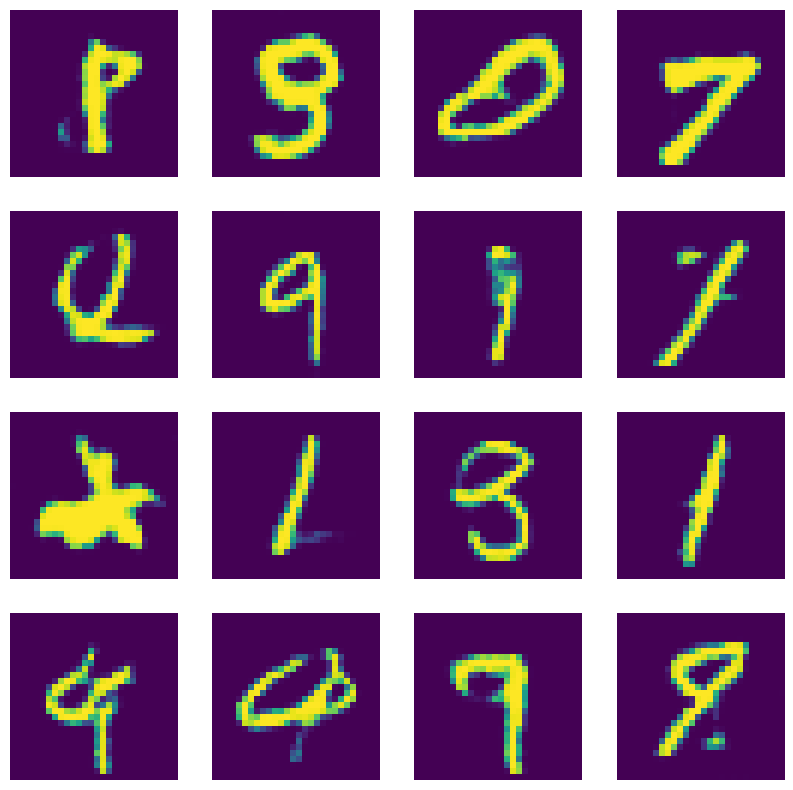

938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3456 - g_loss: 0.8540
Epoch 47/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3470 - g_loss: 0.8527
Epoch 48/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - d_loss: 1.3460 - g_loss: 0.8534
Epoch 49/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3457 - g_loss: 0.8547
Epoch 50/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3459 - g_loss: 0.8535
Epoch 51/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - d_loss: 1.3457 - g_loss: 0.8535

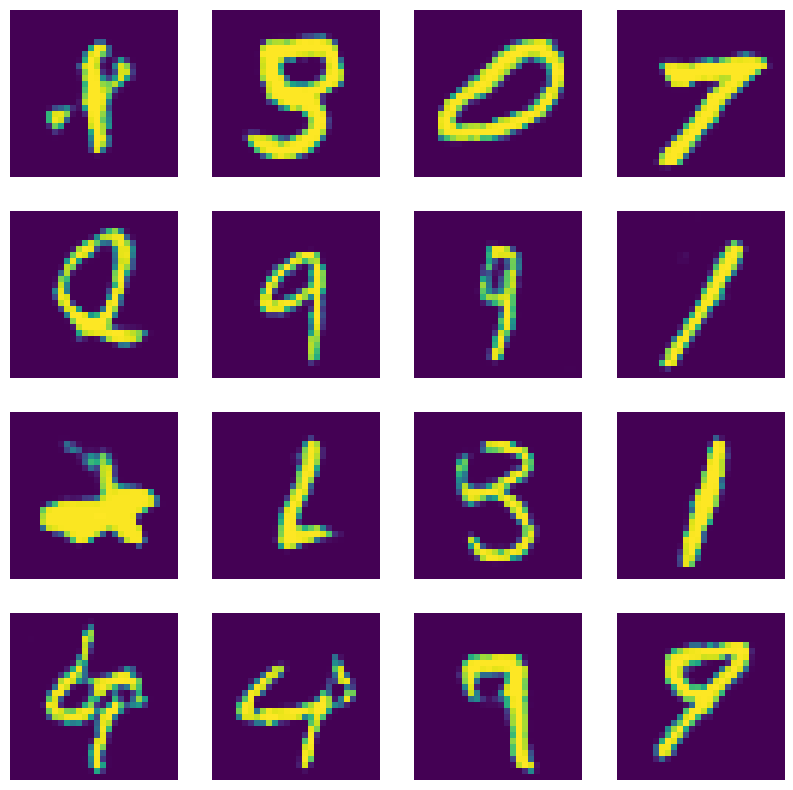

938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - d_loss: 1.3458 - g_loss: 0.8533
Epoch 52/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3461 - g_loss: 0.8533
Epoch 53/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - d_loss: 1.3457 - g_loss: 0.8548
Epoch 54/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - d_loss: 1.3440 - g_loss: 0.8548
Epoch 55/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3446 - g_loss: 0.8547
Epoch 56/100
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - d_loss: 1.3457 - g_loss: 0.8529

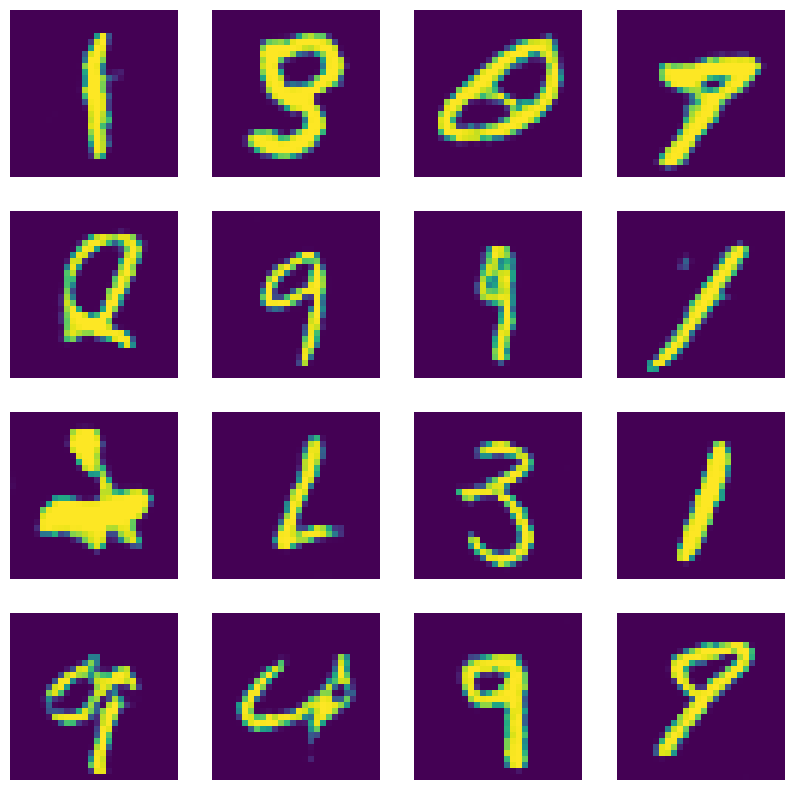

938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3457 - g_loss: 0.8529
Epoch 57/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3442 - g_loss: 0.8553
Epoch 58/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3451 - g_loss: 0.8541
Epoch 59/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - d_loss: 1.3447 - g_loss: 0.8563
Epoch 60/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - d_loss: 1.3444 - g_loss: 0.8555
Epoch 61/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - d_loss: 1.3462 - g_loss: 0.8552

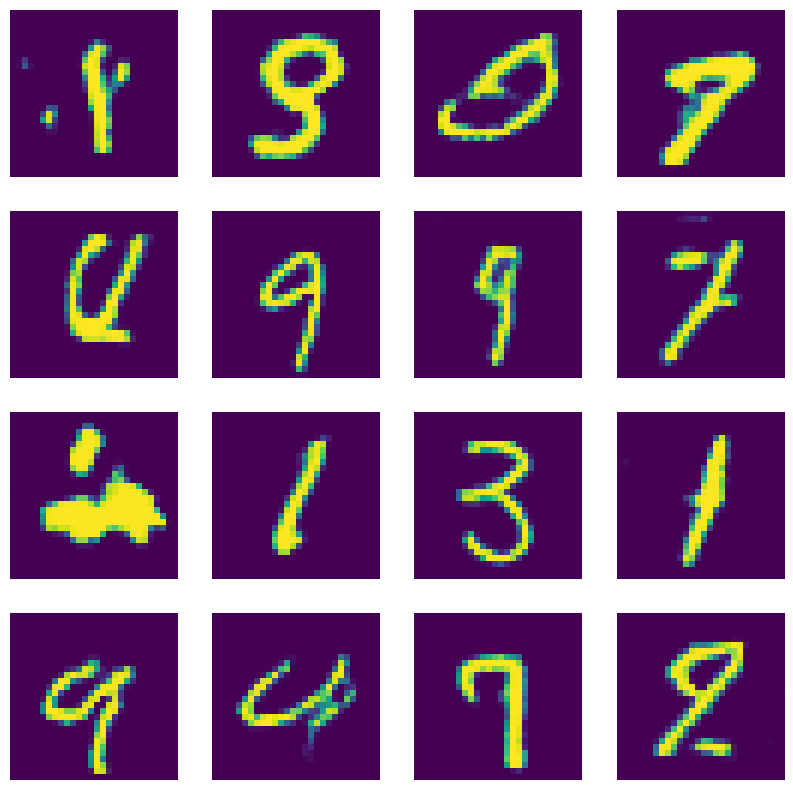

938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - d_loss: 1.3461 - g_loss: 0.8551
Epoch 62/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3441 - g_loss: 0.8551
Epoch 63/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3461 - g_loss: 0.8542
Epoch 64/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3459 - g_loss: 0.8553
Epoch 65/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3466 - g_loss: 0.8550
Epoch 66/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - d_loss: 1.3469 - g_loss: 0.8561

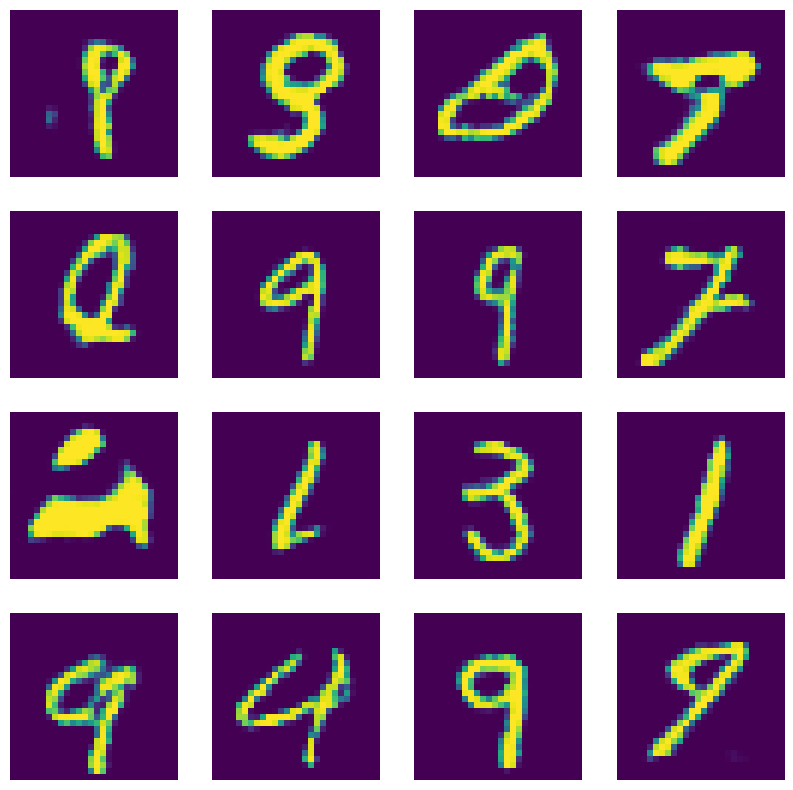

938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3468 - g_loss: 0.8560
Epoch 67/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - d_loss: 1.3466 - g_loss: 0.8544
Epoch 68/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - d_loss: 1.3442 - g_loss: 0.8552
Epoch 69/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - d_loss: 1.3455 - g_loss: 0.8556
Epoch 70/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3461 - g_loss: 0.8549
Epoch 71/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - d_loss: 1.3451 - g_loss: 0.8561

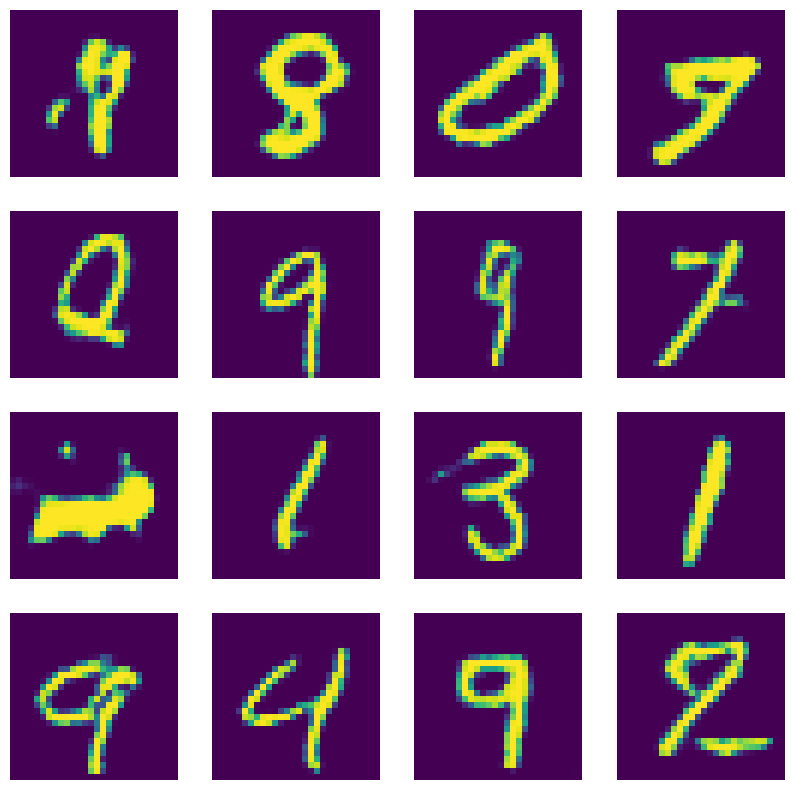

938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - d_loss: 1.3450 - g_loss: 0.8561
Epoch 72/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3462 - g_loss: 0.8571
Epoch 73/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - d_loss: 1.3446 - g_loss: 0.8563
Epoch 74/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3460 - g_loss: 0.8556
Epoch 75/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3469 - g_loss: 0.8572
Epoch 76/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - d_loss: 1.3456 - g_loss: 0.8574

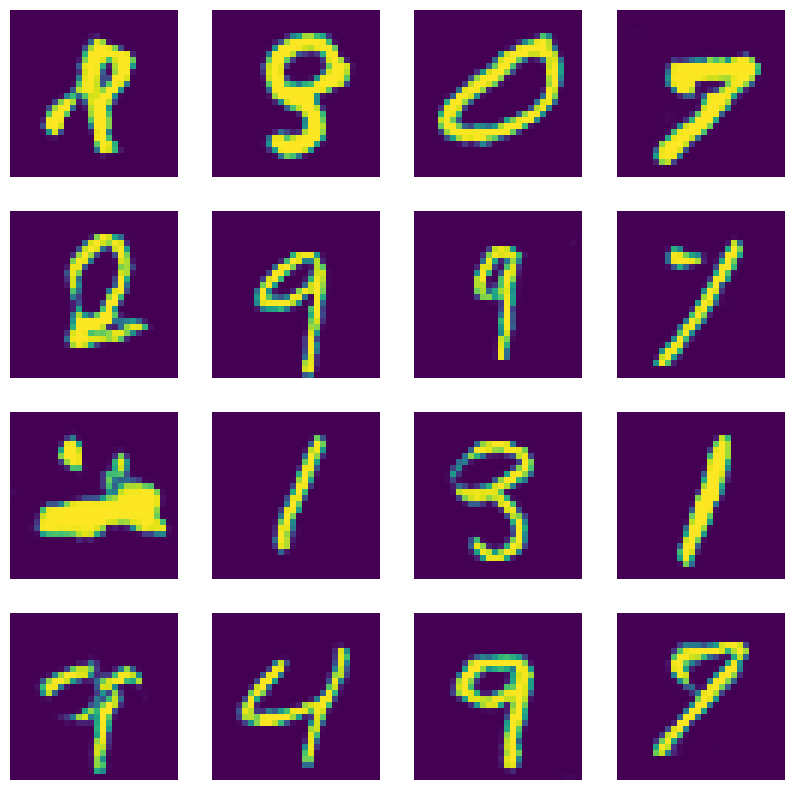

938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3456 - g_loss: 0.8574
Epoch 77/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3446 - g_loss: 0.8561
Epoch 78/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - d_loss: 1.3440 - g_loss: 0.8552
Epoch 79/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3452 - g_loss: 0.8573
Epoch 80/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3453 - g_loss: 0.8563
Epoch 81/100
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - d_loss: 1.3474 - g_loss: 0.8556

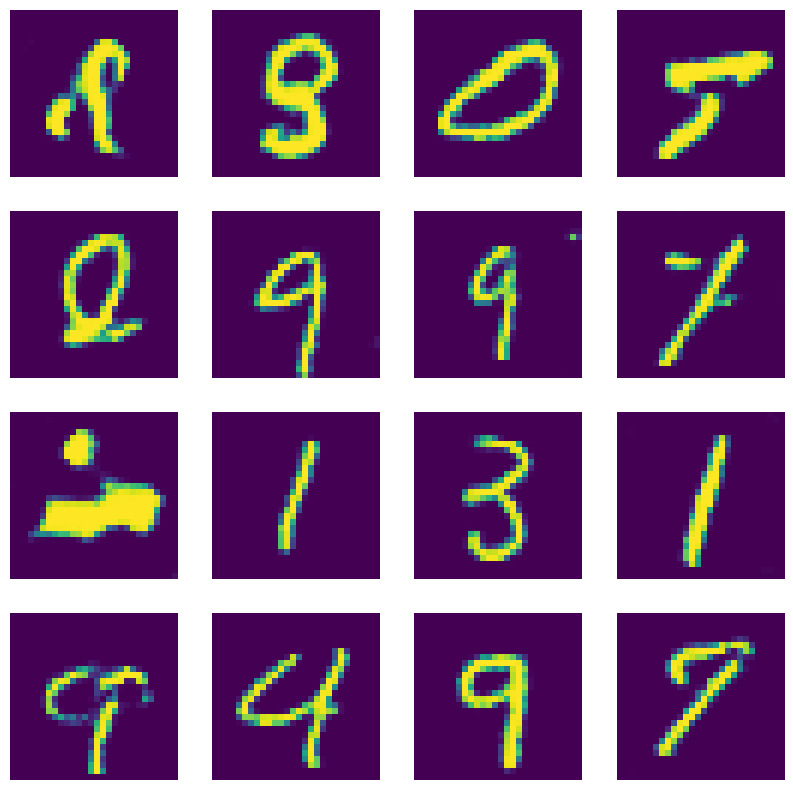

938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - d_loss: 1.3475 - g_loss: 0.8557
Epoch 82/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - d_loss: 1.3469 - g_loss: 0.8558
Epoch 83/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - d_loss: 1.3460 - g_loss: 0.8565
Epoch 84/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3473 - g_loss: 0.8561
Epoch 85/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - d_loss: 1.3473 - g_loss: 0.8575
Epoch 86/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - d_loss: 1.3461 - g_loss: 0.8548

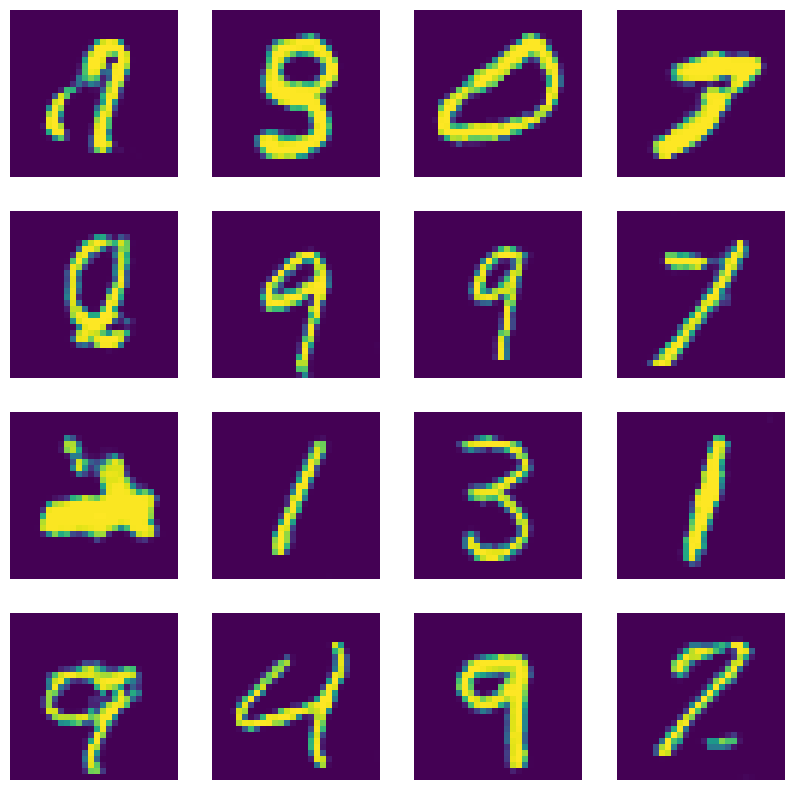

938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - d_loss: 1.3461 - g_loss: 0.8549
Epoch 87/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3467 - g_loss: 0.8561
Epoch 88/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3459 - g_loss: 0.8576
Epoch 89/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - d_loss: 1.3451 - g_loss: 0.8554
Epoch 90/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3453 - g_loss: 0.8549
Epoch 91/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - d_loss: 1.3451 - g_loss: 0.8564

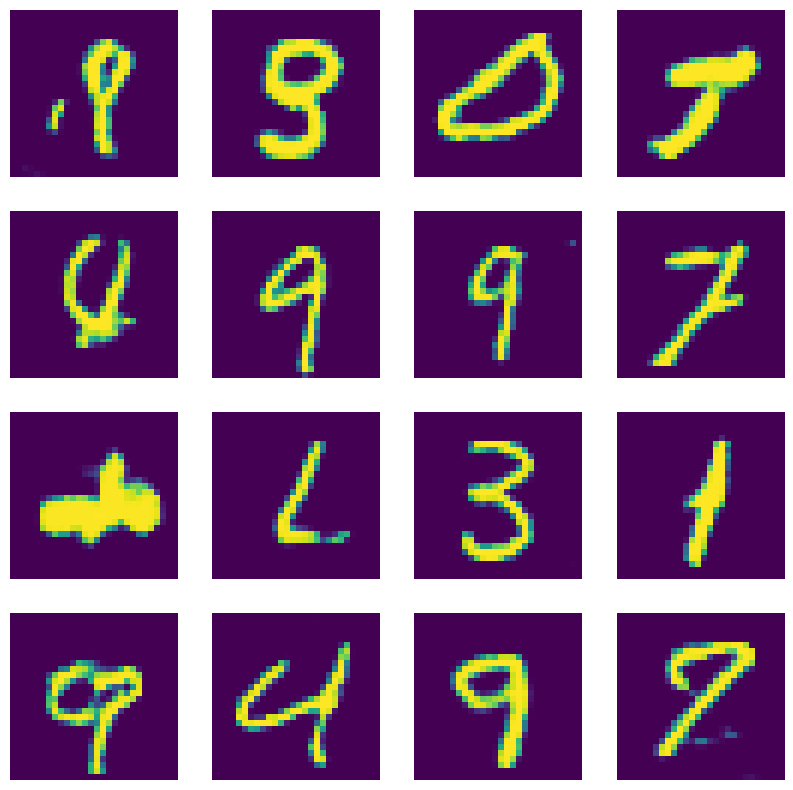

938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3453 - g_loss: 0.8563
Epoch 92/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3456 - g_loss: 0.8565
Epoch 93/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3462 - g_loss: 0.8559
Epoch 94/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3472 - g_loss: 0.8547
Epoch 95/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - d_loss: 1.3467 - g_loss: 0.8575
Epoch 96/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - d_loss: 1.3470 - g_loss: 0.8538

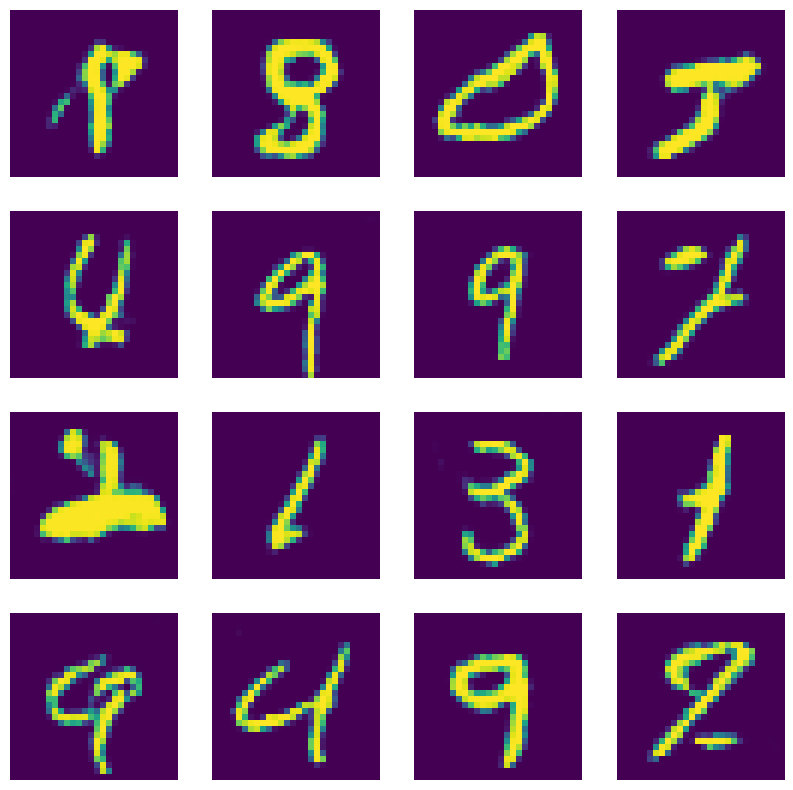

938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - d_loss: 1.3471 - g_loss: 0.8538
Epoch 97/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3455 - g_loss: 0.8562
Epoch 98/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - d_loss: 1.3458 - g_loss: 0.8566
Epoch 99/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - d_loss: 1.3466 - g_loss: 0.8554
Epoch 100/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - d_loss: 1.3479 - g_loss: 0.8543


In [ ]:
history = gan.fit(train_dataset, epochs=EPOCH, callbacks=[ImageCallback()])

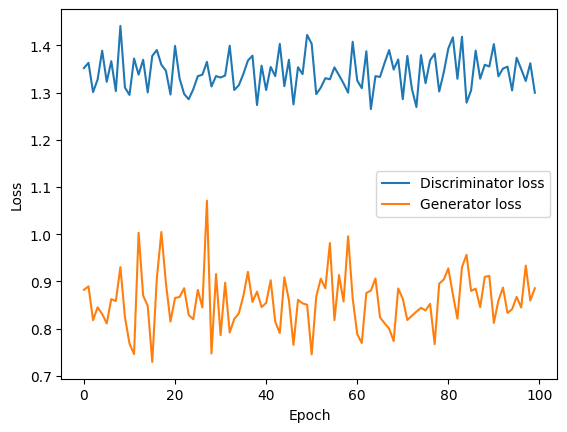

In [ ]:
plt.plot(history.history['d_loss'], label='Discriminator loss')
plt.plot(history.history['g_loss'], label='Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Test the generator
noise = tf.random.normal([25, LATENT_DIM])
generated_images = generator(noise)
generated_images = (generated_images * 127.5) + 127.5

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

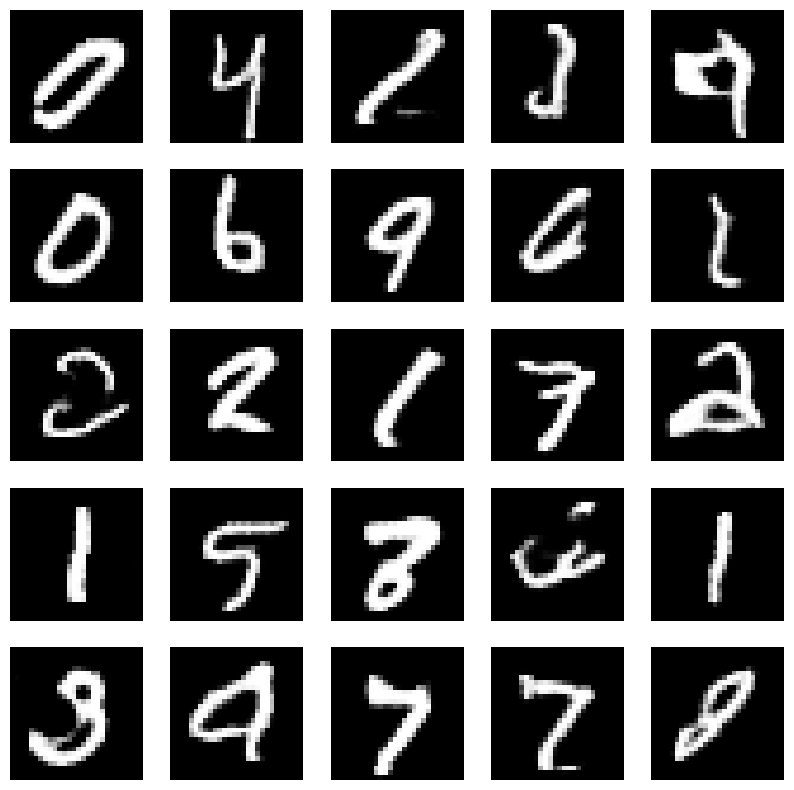

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
  plt.axis("off")
plt

In [ ]:
generator.save("MNIST(handwritten).h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
generator.save('/content/drive/MyDrive/MNIST(handwritten).h5')